Processando evento 0 de 10000...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000 de 10000...
Pr

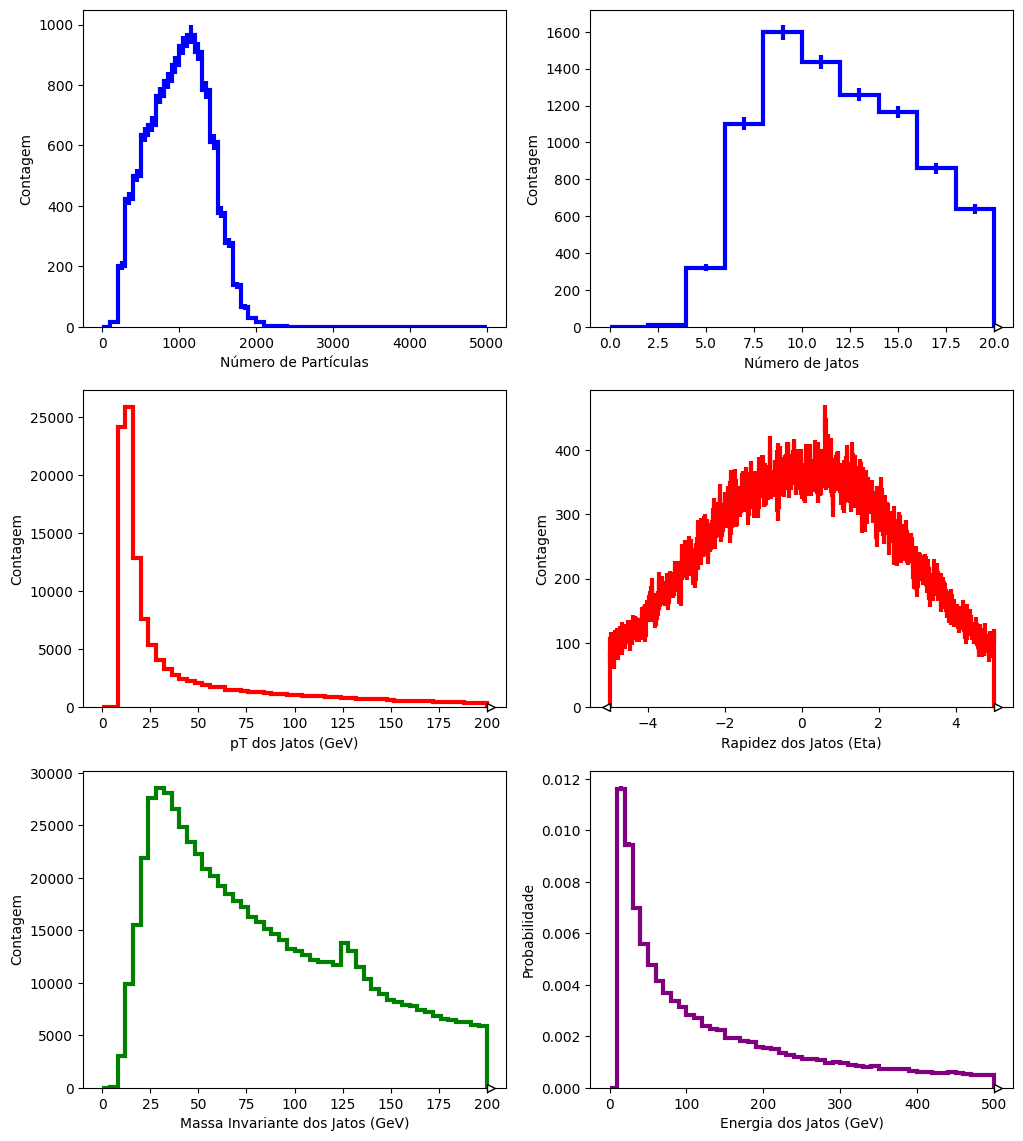

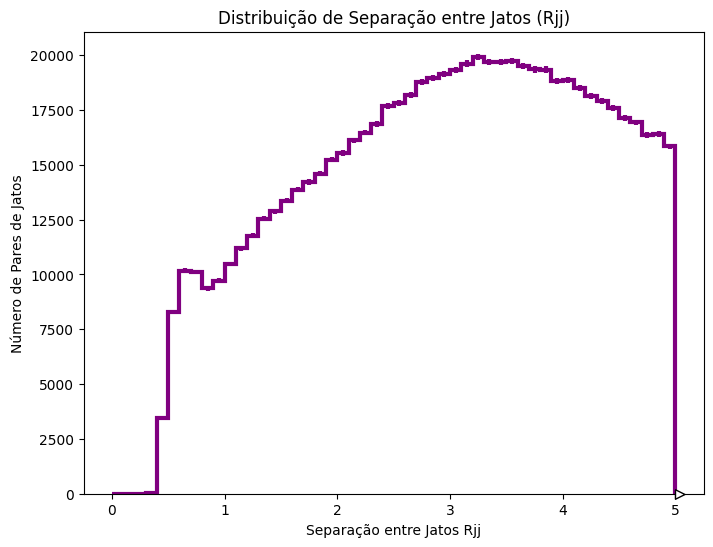

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets  = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt  = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante dos jatos
histo_npart  = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()  # Energia dos jatos
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  # Separação entre jatos (Rjj)

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular o momento transversal (pT)
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para calcular a energia de uma partícula
def get_energy(particle):
    return particle.momentum.e

# Função para calcular a separação Rjj entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = jet1.phi() - jet2.phi()
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Função para calcular a massa invariante de dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar o evento e preencher os histogramas de jatos
def analyze_event(event):
    # Filtrar partículas com pT > 10 GeV para reconstruir jatos
    particles = [p for p in event.particles if p.status == 1]  # Somente partículas finais (status 1)
    
    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = []
    for p in particles:
        fj_particle = fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        fj_particles.append(fj_particle)

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4 
    
    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(10.0)  # Jatos com pT > 10 GeV 
    # Preencher histogramas de jatos
    njets = len(jets)
    histo_njets.fill(njets)
    
    # Preencher histogramas de pT, eta, energia e massa dos jatos
    for jet in jets:
        histo_jets_pt.fill(jet.pt())  # Preencher o histograma de pT dos jatos
        histo_jets_eta.fill(jet.eta())  # Preencher o histograma de eta dos jatos
        histo_jets_energy.fill(jet.e())  # Preencher o histograma de energia dos jatos
        
    # Preencher histograma de massa invariante dos jatos
    if len(jets) >= 2:
        for i in range(len(jets)-1):
            for j in range(i+1, len(jets)):
                mass = invariant_mass(jets[i], jets[j])
                histo_jets_mass.fill(mass)

                # Preencher histograma de separação Rjj entre os jatos
                rjj = delta_r(jets[i], jets[j])
                histo_rjj.fill(rjj)

    # Número de partículas no evento
    npart = len(particles)
    histo_npart.fill(npart)

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(3, 2, figsize=(12, 14))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    # Plot para a Distribuição de Energia dos Jatos no eixo [2,1]
    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3, density=True)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Probabilidade')

    # Histograma de separação Rjj entre jatos
    plt.figure(figsize=(8, 6))
    histo_rjj.plot(ls="-", color="purple", lw=3)
    plt.xlabel('Separação entre Jatos Rjj')
    plt.ylabel('Número de Pares de Jatos')
    plt.title('Distribuição de Separação entre Jatos (Rjj)')
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
nevt = len(events)
for ievt in range(nevt):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {nevt}...")

    event = events[ievt]

    # Analisar o evento e preencher os histogramas
    analyze_event(event)

# Plotar os histogramas
plot_histograms()

Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


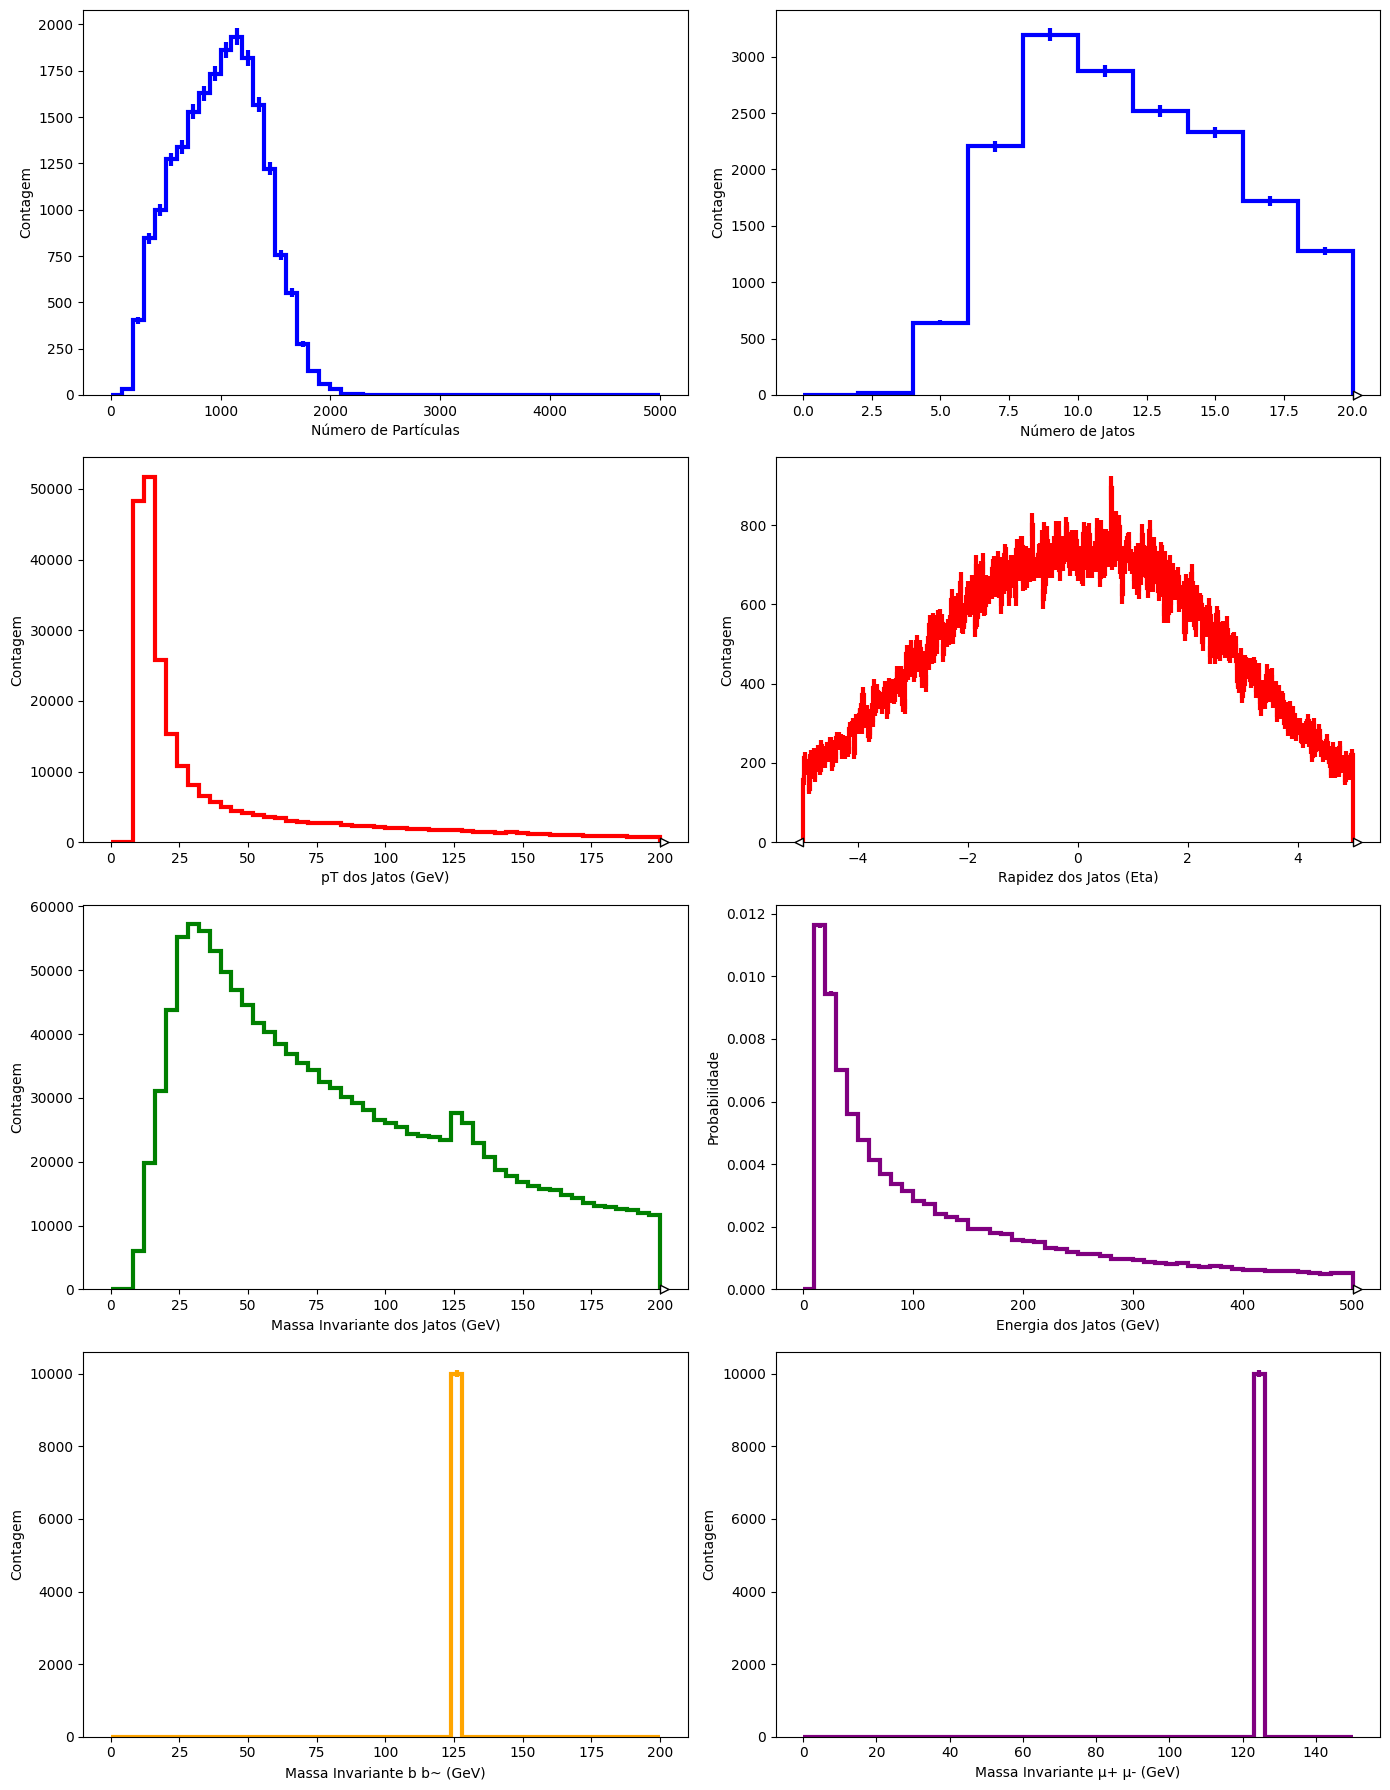

In [2]:
# Definir histogramas para massas invariante dos produtos do Higgs
histo_mass_bb = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante do par b b~
histo_mass_mumu = hist.Hist.new.Reg(50, 0., 150.).Double()  # Massa invariante do par mu+ mu-

# Função para identificar partículas filhas do Higgs
def find_higgs_decay_products(event, pdg_id_higgs=25):
    """
    Identifica os pares de partículas originados do decaimento do Higgs.
    Args:
    - event: evento do HEPMC.
    - pdg_id_higgs: ID do Higgs (25).
    Returns:
    - decay_products: dicionário com listas de partículas b, b~ e mu+, mu-.
    """
    decay_products = {"b": [], "bbar": [], "mu+": [], "mu-": []}
    
    for vertex in event.vertices:
        # Verificar se o vértice possui uma partícula mãe que é o Higgs
        mothers = [p for p in vertex.particles_in if abs(p.pid) == pdg_id_higgs]
        if mothers:
            # Coletar partículas filhas específicas
            for particle in vertex.particles_out:
                if particle.pid == 5:  # b
                    decay_products["b"].append(particle)
                elif particle.pid == -5:  # b~
                    decay_products["bbar"].append(particle)
                elif particle.pid == 13:  # mu-
                    decay_products["mu-"].append(particle)
                elif particle.pid == -13:  # mu+
                    decay_products["mu+"].append(particle)
    return decay_products

# Função para calcular e preencher os histogramas de massa invariante
def analyze_higgs_decays(event):
    decay_products = find_higgs_decay_products(event)
    
    # Massa invariante do par b b~
    if decay_products["b"] and decay_products["bbar"]:
        for b in decay_products["b"]:
            for bbar in decay_products["bbar"]:
                mass_bb = invariant_mass_from_particles(b, bbar)
                histo_mass_bb.fill(mass_bb)
    
    # Massa invariante do par mu+ mu-
    if decay_products["mu+"] and decay_products["mu-"]:
        for mu_plus in decay_products["mu+"]:
            for mu_minus in decay_products["mu-"]:
                mass_mumu = invariant_mass_from_particles(mu_plus, mu_minus)
                histo_mass_mumu.fill(mass_mumu)

# Função para calcular a massa invariante diretamente de partículas do evento
def invariant_mass_from_particles(p1, p2):
    E_tot = p1.momentum.e + p2.momentum.e
    px_tot = p1.momentum.x + p2.momentum.x
    py_tot = p1.momentum.y + p2.momentum.y
    pz_tot = p1.momentum.z + p2.momentum.z
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Atualizar o loop de análise de eventos
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {nevt}...")
    analyze_event(event)  # Analisar jatos
    analyze_higgs_decays(event)  # Analisar decaimentos do Higgs

# Atualizar a função de plotagem
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 18))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3, density=True)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Probabilidade')

    histo_mass_bb.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='Massa Invariante b b~ (GeV)', ylabel='Contagem')

    histo_mass_mumu.plot(ax=ax[3, 1], ls="-", color="purple", lw=3)
    ax[3, 1].set(xlabel='Massa Invariante μ+ μ- (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Plotar todos os histogramas
plot_histograms()


Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


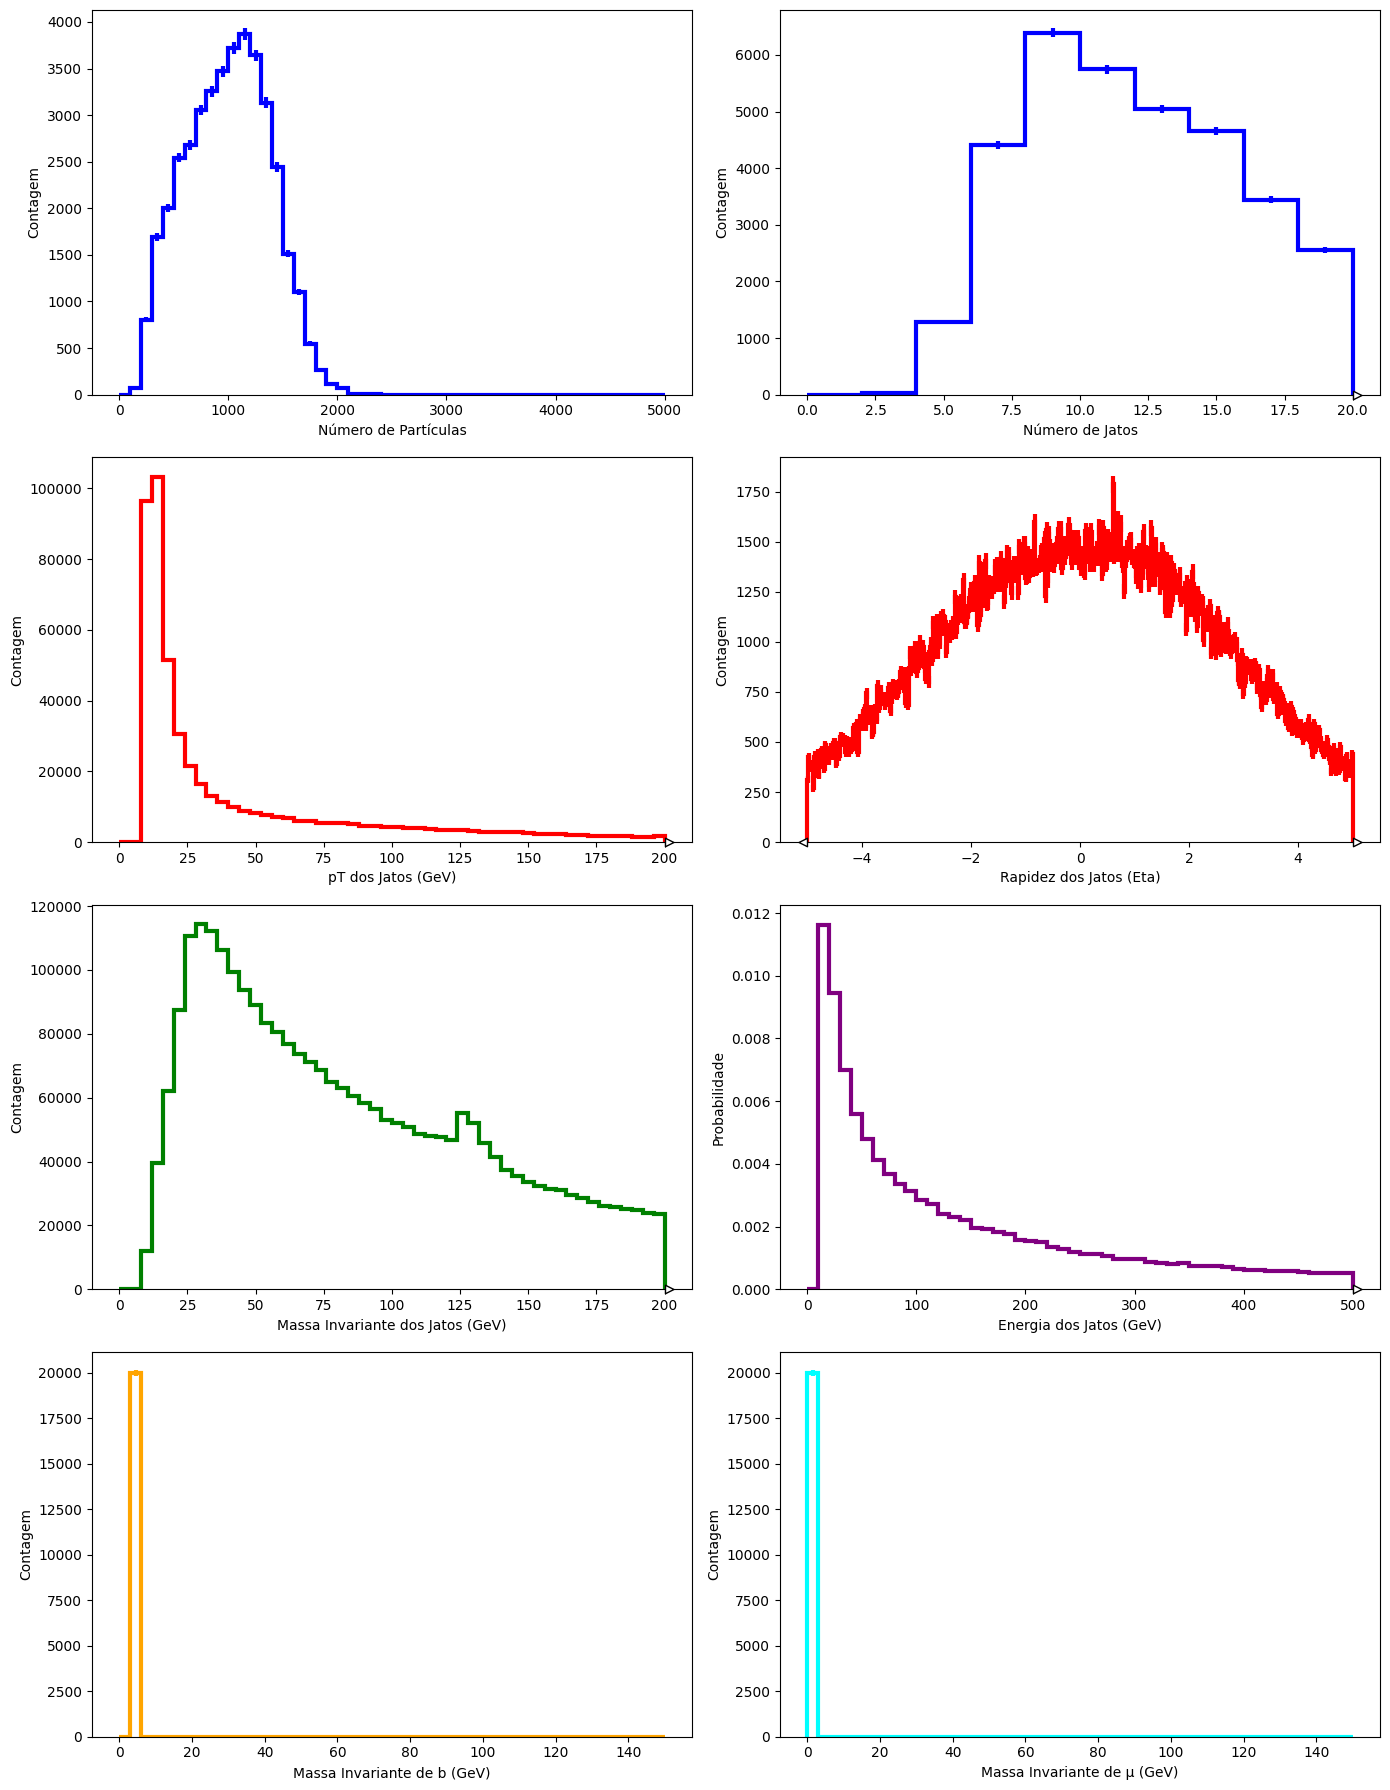

In [4]:
# Definir histogramas para massas invariante μ e b separadamente
histo_mass_b = hist.Hist.new.Reg(50, 0., 150.).Double()  # Massa invariante de cada b
histo_mass_mu = hist.Hist.new.Reg(50, 0., 150.).Double()  # Massa invariante de cada μ

# Função para calcular e preencher histogramas de massa invariante separadamente
def analyze_single_masses(event):
    decay_products = find_higgs_decay_products(event)
    
    # Massa invariante para cada b (ou b~)
    for b in decay_products["b"] + decay_products["bbar"]:
        mass_b = invariant_mass_single_particle(b)
        histo_mass_b.fill(mass_b)
    
    # Massa invariante para cada μ (ou μ+ e μ-)
    for mu in decay_products["mu+"] + decay_products["mu-"]:
        mass_mu = invariant_mass_single_particle(mu)
        histo_mass_mu.fill(mass_mu)

# Função para calcular a massa invariante de uma única partícula
def invariant_mass_single_particle(particle):
    return np.sqrt(particle.momentum.e**2 - (particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2))

# Atualizar o loop de análise de eventos
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {nevt}...")
    analyze_event(event)         # Analisar jatos
    analyze_higgs_decays(event)  # Analisar decaimentos do Higgs
    analyze_single_masses(event) # Analisar massas invariante μ e b

# Atualizar a função de plotagem para incluir os novos histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 18))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3, density=True)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Probabilidade')

    # Plot para massa invariante de b
    histo_mass_b.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='Massa Invariante de b (GeV)', ylabel='Contagem')

    # Plot para massa invariante de μ
    histo_mass_mu.plot(ax=ax[3, 1], ls="-", color="cyan", lw=3)
    ax[3, 1].set(xlabel='Massa Invariante de μ (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Plotar todos os histogramas
plot_histograms()


Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


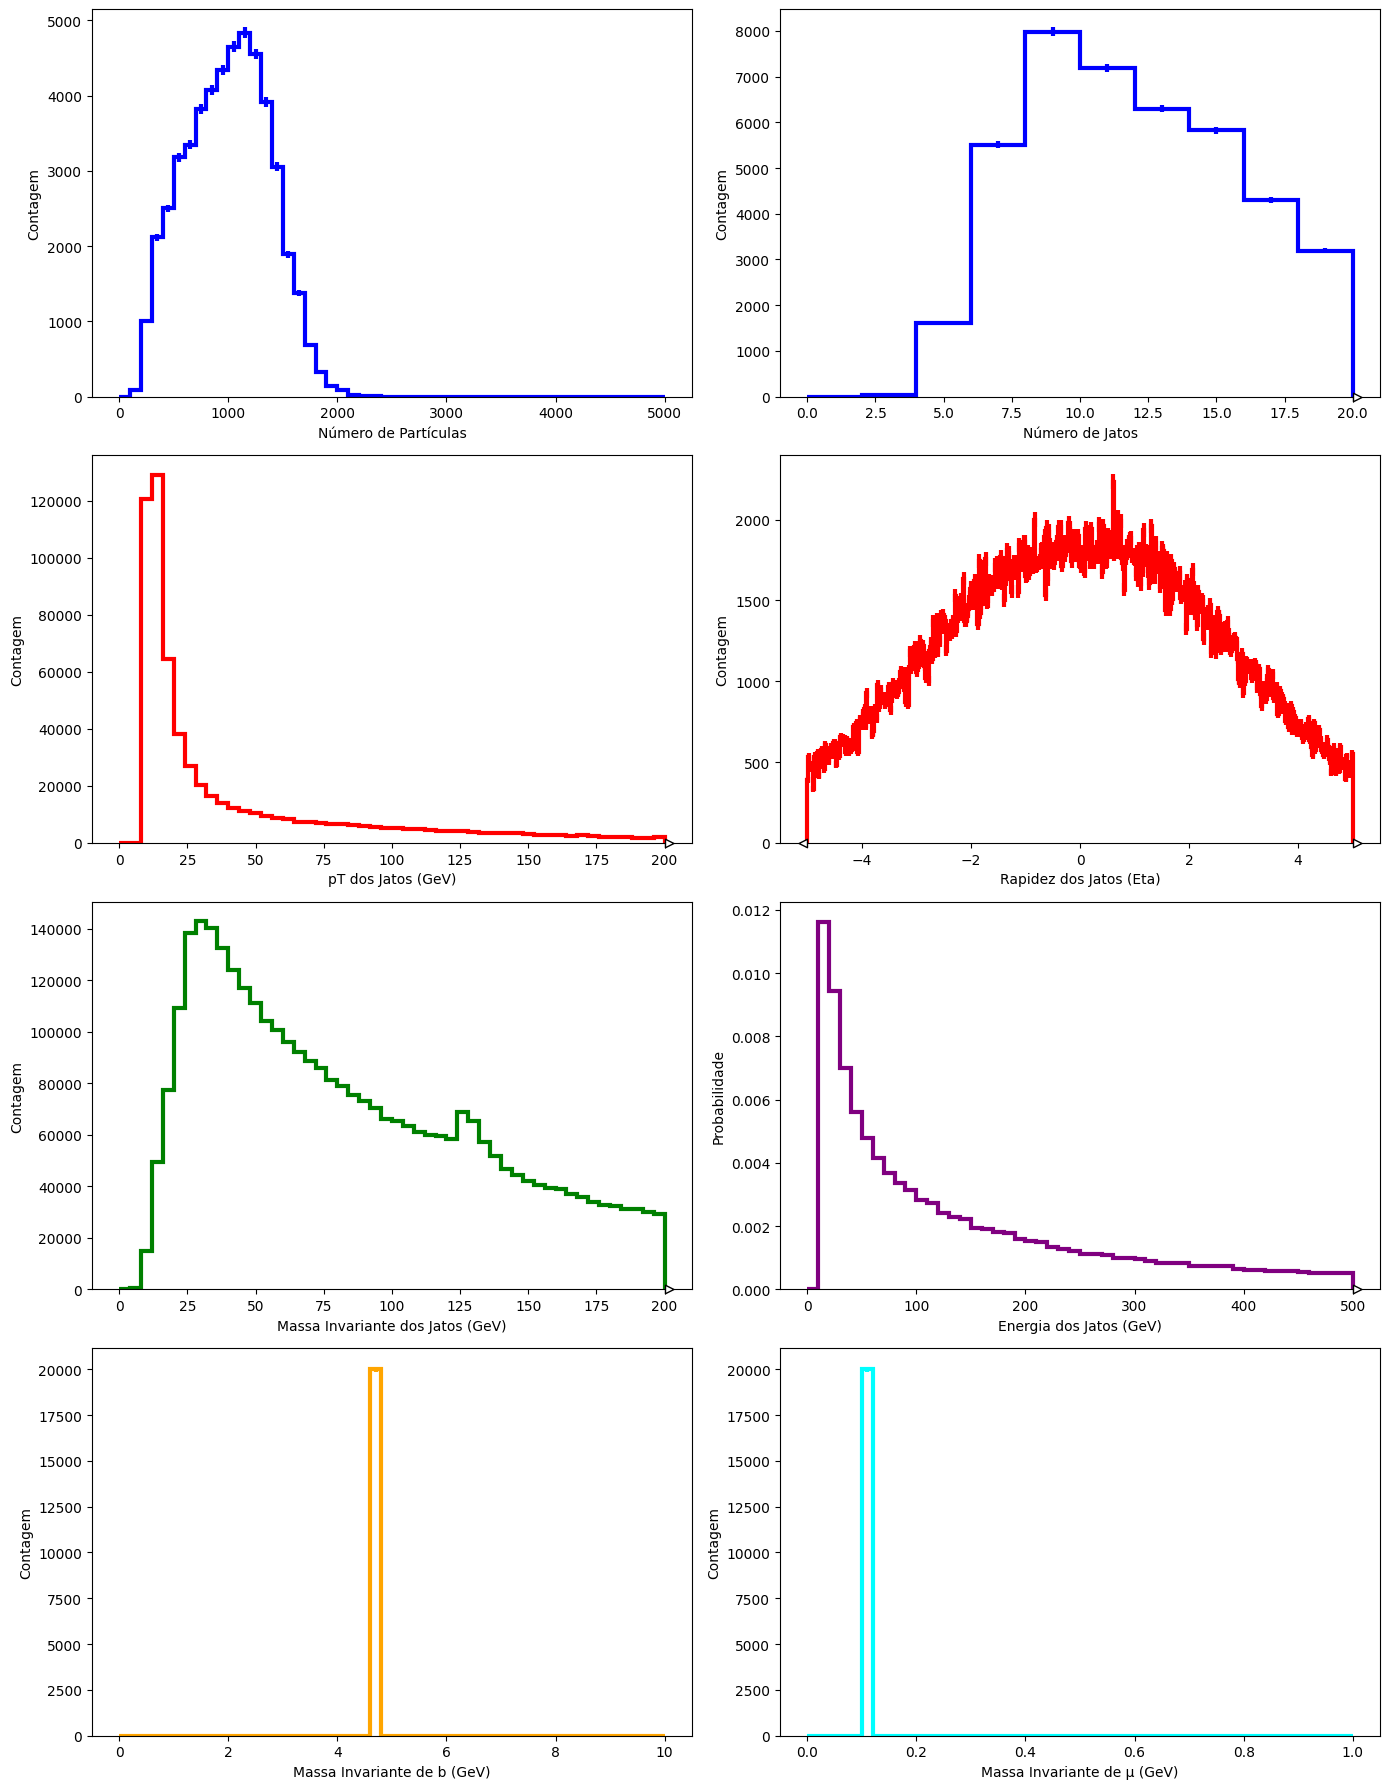

In [5]:
# Ajustar histogramas com limites adequados
histo_mass_b = hist.Hist.new.Reg(50, 0., 10.).Double()   # Massa invariante de cada b
histo_mass_mu = hist.Hist.new.Reg(50, 0., 1.).Double()   # Massa invariante de cada μ

# Função para calcular e preencher histogramas de massa invariante separadamente
def analyze_single_masses(event):
    decay_products = find_higgs_decay_products(event)
    
    # Massa invariante para cada b (ou b~)
    for b in decay_products["b"] + decay_products["bbar"]:
        mass_b = invariant_mass_single_particle(b)
        histo_mass_b.fill(mass_b)
    
    # Massa invariante para cada μ (ou μ+ e μ-)
    for mu in decay_products["mu+"] + decay_products["mu-"]:
        mass_mu = invariant_mass_single_particle(mu)
        histo_mass_mu.fill(mass_mu)

# Função para calcular a massa invariante de uma única partícula
def invariant_mass_single_particle(particle):
    return np.sqrt(particle.momentum.e**2 - (particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2))

# Atualizar o loop de análise de eventos
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {nevt}...")
    analyze_event(event)         # Analisar jatos
    analyze_higgs_decays(event)  # Analisar decaimentos do Higgs
    analyze_single_masses(event) # Analisar massas invariante μ e b

# Atualizar a função de plotagem para incluir os novos histogramas
def plot_histograms():
    fig, ax = plt.subplots(4, 2, figsize=(14, 18))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3, density=True)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Probabilidade')

    # Plot para massa invariante de b
    histo_mass_b.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='Massa Invariante de b (GeV)', ylabel='Contagem')

    # Plot para massa invariante de μ
    histo_mass_mu.plot(ax=ax[3, 1], ls="-", color="cyan", lw=3)
    ax[3, 1].set(xlabel='Massa Invariante de μ (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Plotar todos os histogramas
plot_histograms()
